[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/EDA_ninapro_DB1/blob/main/ME03%20-%20G12%20-%20%5B70698438%5D-%5B98583652%5D.ipynb)

# Base de datos Ninapro DB1

#### Introducción

Las bases de datos de Ninapro (Non-Invasive Adaptive Prosthetics Database) ([link](https://ninapro.hevs.ch/)) son colecciones de datos que contienen información de señales de electromiografía (EMG) y otros sensores, diseñadas para investigar el control de prótesis mioeléctricas. En nuestro caso, se seleccion la colección Ninapro DB1 ([link](https://ninapro.hevs.ch/instructions/DB1.html)) cuya descripción se resume en la siguiente tabla:

| **Características**            | **Descripción**                                                                 |
|--------------------------------|---------------------------------------------------------------------------------|
| **Participantes**              | 27 sujetos sanos  (mujeres y hombres)                                           |
| **Electrodos**                 | 10 electrodos de superficie colocados en el antebrazo                           |
| **Frecuencia de Muestreo**     | 100 Hz                                                                          |
| **Movimientos Registrados**    | 52 movimientos de mano y dedos (gestos básicos, isométricos y dinámicos)        |
| **Sensores Adicionales**       | Acelerómetro 3D para capturar datos de movimiento (ejes X, Y, Z)                |
| **Propósito**                  | Investigación para mejorar el control de prótesis de mano basada en señales EMG |
| **Duración de Cada Registro**  | Cada movimiento dura alrededor de 5 segundos                                    |
| **Etiquetas de Movimiento**    | Cada registro está etiquetado con el tipo de movimiento realizado               |

La información obtenida de los sensores por sujero es almacenada en un archivo comprimido de la forma **`sx.zip`** (Donde `x` es el numero del sujeto). El archivo asociado a cada sujeto tiene tres archivos MAT (archivos Matlab) asociado a tres tips de ejercicios compuestos de diferentes posturas como se muestra en la siguiente tabla:

|Ejercicio|Movimientos|Descripción|
|----|----|----|
|1|	12|	Individuales de dedos|
|2|	17|	Agarres y posturas de mano|
|3|	23|	Gestos funcionales|

Nuestro analisis, se limito solo al analisis de los movimientos del realizados en el ejercicio 1 y solo tentra en cuenta las muestras capturadas por los electrodos de superficie (sEMG). 

![movimientos-1](./movimientos1.png)

De acuerdo con lo anteior, el notebook combinara todos los archivos MAT del ejercicio 1 para los 27 sujetos en un unico Dataframe. Luego, analizara este dataframe y se dara contexto al problema; posteriormente se aplicaran sobre las señales sEMG almacenadas un proceso de preprocesamiento y filtrado de las señales. Finalmente, se realizara un proceso de extracción de caracteristicas segmemtando la señal y obteniendo para cada segmento las un vector caracteristico (por ahora solo con los valore RMS de cada sensor). Finalmente, se realizará un analisis exploratorio sobre los vectores caracteristicos y se almacenaran para trabajos futuros.

A continuación se describe en el indice principal, las principales partes del notebook que se encarga de llevar a cabo todo lo anterior.

#### Indice principal

1. Librerias y configuraciones previas [link](#1-librerias-y-configuraciones-previas)
2. Funciones [link](#2-funciones)
3. Carga del dataset crudo [link](#3-carga-del-dataset-crudo)
4. Preprocesamiento de las señales de la base de datos [link](#4-preprocesamiento-de-las-señales-de-la-base-de-datos)
5. Extracción de caracteristicas [link](#5-extracción-de-caracteristicas)
6. Analisis Exploratiorio de los datos (EDA) [link](#6-analisis-exploratorio-de-los-datos)
7. Conclusiones [link](#7-conclusiones)
8. Referencias [link](#8-referencias)

## 1. Librerias y configuraciones previas

Instalación de librerias externas necesarias

In [1]:
import sys

# Solo ejecute una unica vez si no tiene instalada la libreria
!{sys.executable} -m pip install -U ydata-profiling[notebook]
!pip install jupyter-contrib-nbextensions

In [2]:
# Instalacion de libreria scipy
try:
    import scipy.io
except ImportError:
    !pip install scipy

Configuración del entorno en el cual se ejecutará el notebook 

In [3]:
import os
import requests

# Get the absolute path of the current notebook
base_path = "."
eda_results_path = "./"
raw_datasets_path = "./raw_datasets/"
datasets_path = "./datasets/"
raw_datasets_url = "https://github.com/repos-especializacion-UdeA/EDA_ninapro_DB1/raw/refs/heads/main/raw_datasets/" 
try:
    import google.colab    
    print("Ejecucion del notebook en Colab")
    %mkdir /content/raw_datasets
    raw_datasets_path = "/content/raw_datasets/"
    %mkdir /content/datasets
    datasets_path = "/content/datasets/"
    eda_results_path = "/content/"
    %mkdir /content/html_report
    %mkdir /content/json_report
    for i in range(1,28):        
        url = raw_datasets_url +"S" + str(i) + "_A1_E1.mat"
        print(url)
        mat_file_path = raw_datasets_path + "S" + str(i) + "_A1_E1.mat"
        f = open(mat_file_path,'wb')
        r = requests.get(url)
        f.write(r.content)          
        print(f"Archivo S{i}_A1_E1.mat descargado")
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [5]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import scipy as sc
from ydata_profiling import ProfileReport

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

## 2. Funciones

In [6]:
# ==============================================================================
# Funciones externas
# ==============================================================================

def indice_postura(estimulo_data, num):
  """
  Calcula los indices inicial y final asociados a una postura determinadoa.

  Parámetros:
  -----------
  estimulo_data : list or array-like
    Datos de los 10 sensores sEMG.

  num : int
    Numero de la postura de la mano (valor entre 1 y 12)

  Retorna:
  --------
    tuple
        Indice inicial y final del ejercicio en cuestion (contiene los periodos de descanso).
  
  Ejemplo:
  --------
  >>> indice_postura(label_data,1)
  """
  # Cuando se lee un dataframe
  if isinstance(estimulo_data, pd.DataFrame):
    if num == 1:
      return (0,estimulo_data.index[estimulo_data == num][-1])
    else:
      index_cambios_anterior = (estimulo_data.index[estimulo_data == num - 1][0],estimulo_data.index[estimulo_data == num][-1])
      return (index_cambios_anterior[1],estimulo_data.index[estimulo_data == num][-1])
  else:
    # Cuando se lee un np array
    index_cambios = np.where(estimulo_data == num)[0]
    if num == 1:      
      return (0,index_cambios[-1])
    else:
      index_cambios_anterior = np.where(estimulo_data == num - 1)[0]
      return (index_cambios_anterior[-1] + 1,index_cambios[-1])

# ==============================================================================

def segmentar_data_set( data_set, 
                        window_size = 20, 
                        overlap_size = 0):
    """
    Segmenta un conjunto de datos en ventanas de tamaño fijo con un solapamiento opcional.

    Esta función divide un conjunto de datos en segmentos de tamaño especificado, permitiendo 
    un solapamiento entre ventanas consecutivas. Es útil para el procesamiento de datos en ventanas 
    en tareas de análisis de señales o series temporales.

    Parámetros:
    -----------
    data_set : list o array-like
        El conjunto de datos a segmentar. 

    window_size : int, opcional
        El tamaño de cada ventana o segmento en el que se dividirá el conjunto de datos. 
        El valor predeterminado es 20.

    overlap_size : int, opcional
        El tamaño de la superposición entre ventanas consecutivas. Un valor de 0 indica 
        que no hay solapamiento, mientras que un valor mayor permitirá que las ventanas 
        compartan datos entre sí. El valor predeterminado es 0.

    Retorna:
    --------
    list
        Una lista de ventanas (subconjuntos) del conjunto de datos original, cada una de tamaño 
        `window_size`, y con el solapamiento especificado por `overlap_size`. Cada ventana es una 
        lista de valores que representan una porción del conjunto de datos.

    Ejemplo:
    --------
    >>> data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    >>> segmentar_data_set(data, window_size=3, overlap_size=1)
    [[1, 2, 3], [3, 4, 5], [5, 6, 7], [7, 8, 9], [9, 10]]
    
    En este ejemplo, el conjunto de datos se segmenta en ventanas de tamaño 3 con un solapamiento 
    de 1 entre ventanas consecutivas.

    Agradecimiento: 
    --------
    A la IA antepasado de Skynet que documento esto por nosotros
    """

    if len(data_set.columns) != 13:
        print("Dataset incompleto, revise las columnas")
        return -1

    sujeto_data = data_set.iloc[:,0]        # s
    emg_data = data_set.iloc[:,1:11]        # emg_1, emg_2, emg_3, ..., emg_10   
    postura_data =  data_set.iloc[:,-1]     # label
    repeticion_data = data_set.iloc[:,-2]   # rep

    ventanas = []
    ventana = pd.DataFrame()
    step_size = window_size - overlap_size
    for i in range(0, len(emg_data) - window_size + 1, step_size):
        sujeto_window = sujeto_data.iloc[i:i + window_size]
        label_window = postura_data.iloc[i:i + window_size]
        rep_window = repeticion_data.iloc[i:i + window_size]
        num_unique_labels = label_window.nunique()
        if isinstance(num_unique_labels, int) and num_unique_labels == 1: 
            ventana = pd.concat([sujeto_window.copy().reset_index(drop=True), 
                                 emg_data.iloc[i:i + window_size].copy().reset_index(drop=True), 
                                 rep_window.copy().reset_index(drop=True),
                                 label_window.copy().reset_index(drop=True)], 
                                 axis=1)
            ventanas.append(ventana)
    return ventanas

# ==============================================================================

def rms_value(emg_values):
    """
    Calcula el valor RMS (Root Mean Square) de un conjunto de valores EMG (Ventana).

    Parámetros:
    -----------
    emg_values : list o array-like
        Conjunto de valores numéricos de una señal EMG (electromiografía) o cualquier 
        otra señal en la que se desee calcular el valor RMS. 

    Retorna:
    --------
    float
        El valor RMS de los datos de entrada, que representa la magnitud media cuadrática 
        de la señal y proporciona una medida de su potencia.

    Ejemplo:
    --------
    >>> emg_values = [0.5, 1.5, -1.2, 0.3, -0.8]
    >>> rms_value(emg_values)
    0.975

    En este ejemplo, el valor RMS de la lista de valores EMG proporcionada es 0.975.
    
    Agradecimiento: 
    --------
    A la IA antepasado de Skynet que nos paso el codigo.
    """
    if not isinstance(emg_values, pd.DataFrame):
        raise TypeError("La ventana deben ser un dataframe")
    rms_emg_values = emg_values.apply(lambda x: np.sqrt(np.mean(np.square(x))), axis=0)
    rms_df = pd.DataFrame([rms_emg_values])
    return rms_df 

# Valor MAV (Mean Absolute Value)
def mav_value(emg_values):
    """
    Calcula el valor MAV (Mean Absolute Value) de un conjunto de valores EMG.

    Parámetros:
    -----------
    emg_values : list o array-like
        Conjunto de valores numéricos de una señal EMG (electromiografía) o cualquier 
        otra señal en la que se desee calcular el valor MAV.

    Retorna:
    --------
    float
        El valor MAV de los datos de entrada, que representa la magnitud promedio 
        de la señal en valor absoluto.

    Ejemplo:
    --------
    >>> emg_values = [0.5, -1.5, 1.2, -0.3, 0.8]
    >>> mav_value(emg_values)
    0.82

    En este ejemplo, el valor MAV de la lista de valores EMG proporcionada es 0.82.

    Agradecimiento: 
    --------
    A la IA antepasado de Skynet que nos paso el codigo.
    """
    if not isinstance(emg_values, pd.DataFrame):
        raise TypeError("La ventana deben ser un dataframe")
    mav_emg_values = emg_values.apply(lambda x: np.mean(np.abs(x)), axis=0)
    mav_df = pd.DataFrame([mav_emg_values])
    return mav_df


def features_data_set(data_set_windows):
    """
    Extrae características de un conjunto de ventanas de datos.

    Esta función toma un conjunto de ventanas de datos y calcula características específicas 
    para cada ventana, como el valor RMS, MAV u otras estadísticas. Por ahora solo extrae el RMS.

    Parámetros:
    -----------
    data_set_windows : list of list or array-like
        Conjunto de ventanas de datos. Cada ventana debe ser una lista o arreglo de valores numéricos 
        que representan una porción de una señal o serie temporal.

    Retorna:
    --------
    list of dataframes
        Cada elemento de la lista es un dataframe con los valores RMS la señal eEMG para cada sensor.

    Notas:
    ------
    Las características específicas que se calculan para cada ventana pueden variar según la implementación. 
    Es común incluir el valor RMS y MAV, pero se pueden añadir otras métricas estadísticas según sea necesario.

    Agradecimiento: 
    --------
    A la IA antepasado de Skynet que nos genero la documentacion. De hecho, lo hizo mejor de lo que 
    lo hubieramos hecho. Definitivamente la inteligencia artificial supero nuestra inteligencia natural
    """
    # Por ahora solo hace el calculo del RMS
    filas = []  # Lista para almacenar las filas aplanadas
    for i in range(len(data_set_windows)):
        rms_window = pd.DataFrame({'s': [data_set_windows[i].iloc[0,0]]})
        rms_seg = rms_value(data_set_windows[i].iloc[:,1:-2])
        rms_window = pd.concat([rms_window,rms_seg],axis=1)
        rms_window['rep'] = data_set_windows[i].iloc[0,-2]
        rms_window['label'] = data_set_windows[i].iloc[0,-1]
        filas.append(rms_window)  # Agregar a la lista en lugar de concatenar inmediatamente
    # Concatenar todo al final  
    features_data_base = pd.concat(filas, ignore_index=True)
    return features_data_base

## 3. Carga del dataset crudo

El dataset Ninapro DB1 se encuentra en el siguiente [link](https://ninapro.hevs.ch/instructions/DB1.html). Cada uno de los datasets asociados a los sujetos (`sx.zip`) se descargaron manualmente, se descomprimieron y se seccionaron todos los archivos de la forma `Sx_A1_E1.mat`. Estos se agruparon en el directorio [raw_datasets](./raw_datasets/)

In [7]:
archivos_mat = ['S1_A1_E1.mat', 
         'S2_A1_E1.mat', 
         'S3_A1_E1.mat', 
         'S4_A1_E1.mat', 
         'S5_A1_E1.mat', 
         'S6_A1_E1.mat', 
         'S7_A1_E1.mat', 
         'S8_A1_E1.mat', 
         'S9_A1_E1.mat', 
         'S10_A1_E1.mat', 
         'S11_A1_E1.mat', 
         'S12_A1_E1.mat', 
         'S13_A1_E1.mat', 
         'S14_A1_E1.mat', 
         'S15_A1_E1.mat', 
         'S16_A1_E1.mat', 
         'S17_A1_E1.mat', 
         'S18_A1_E1.mat', 
         'S19_A1_E1.mat', 
         'S20_A1_E1.mat', 
         'S21_A1_E1.mat', 
         'S22_A1_E1.mat', 
         'S23_A1_E1.mat', 
         'S24_A1_E1.mat', 
         'S25_A1_E1.mat', 
         'S26_A1_E1.mat',
         'S27_A1_E1.mat']

### 3.1. Analisis de un archivo muestra

Para la visualización de las caracteristicas del archivo MAT cargado. Se toma como muestra el primer archivo MAT (`S1_A1_E1.mat`)

In [8]:
archivo_mat = scipy.io.loadmat(raw_datasets_path + archivos_mat[0])
print(archivo_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


A continuación se describen cada uno de estos campos

|Columna|Descripción|Tipo de dato|
|---|---|---|
|`__header__`|Metadatos del archivo MAT Nominal __version__ Versión del archivo MAT|Nominal|
|`__globals__`|----|----|
|`emg`|Datos de los 10 sensores sEMG| Categórico|
|`stimulus`|Postura que se le indica que haga al sujeto|Categórico|
|`glove`|Datos de los 22 sensores del guante|Numérico|
|`subject`|Sujeto que realiza la prueba (1 - 27)|Categórico|
|`exercise`|Ejercicio (conjunto de posturas) llevada a cabo|Numérico|
|`restimulus`|Postura realizada por el sujeto|Categórico|
|`rerepetition`|Repetición de la postura|Categórico|

#### 3.1.1. Metadatos

Los metadatos asociados cada uno de los archivos Matlab se describen a continuación:

In [9]:
# Metadatos
print("Metadatos del archivo")
for key in list(archivo_mat.keys())[:3]:
    # print(key,": ",archivo_mat[key],sep = "")
    print(f"{key}: {archivo_mat[key]} | tipo:{type(archivo_mat[key])}")

Metadatos del archivo
__header__: b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jul 28 11:54:15 2014' | tipo:<class 'bytes'>
__version__: 1.0 | tipo:<class 'str'>
__globals__: [] | tipo:<class 'list'>


#### 3.1.2. Informacion de los sensores

Las columnas correspondientes a la información de los sensores se muestra a continuación:

In [10]:
# Informacion de los sensores
print("Sensores")
for key in ['emg','glove']:
    f, c = archivo_mat[key].shape
    print(f"{key}: F: {f}; C: {c} | tipo:{type(archivo_mat[key])}")

Sensores
emg: F: 101014; C: 10 | tipo:<class 'numpy.ndarray'>
glove: F: 101014; C: 22 | tipo:<class 'numpy.ndarray'>


#### 3.1.3. Informacion sobre el ejercicio

La información sobre las posturas y las repeticiones asociadas al ejercicio 1 se muestran a continuación:

In [11]:
## Carga de la base de datos
for key in ['subject', 'exercise']:
    f, c = archivo_mat[key].shape
    print(f"{key}: {archivo_mat[key][0,0]} | tipo:{type(archivo_mat[key])}")

subject: 1 | tipo:<class 'numpy.ndarray'>
exercise: 1 | tipo:<class 'numpy.ndarray'>


#### 3.1.4. Estimulos

A continuación se muestra información sobre los estimulos.

In [12]:
## Carga de la base de datos
for key in ['stimulus', 'repetition', 'restimulus', 'rerepetition']:
    f, c = archivo_mat[key].shape
    print(f"{key}: F: {f}; C: {c} | tipo:{type(archivo_mat[key])}")

stimulus: F: 101014; C: 1 | tipo:<class 'numpy.ndarray'>
repetition: F: 101014; C: 1 | tipo:<class 'numpy.ndarray'>
restimulus: F: 101014; C: 1 | tipo:<class 'numpy.ndarray'>
rerepetition: F: 101014; C: 1 | tipo:<class 'numpy.ndarray'>


### 3.2. Combinación de los datasets

A continuación se carga de cada una de las bases de datos asociadas a los sujetos (archivos Matlab) y se combinan en el dataframe `data_base`.

In [13]:
## Carga de la base de datos
raw_df = pd.DataFrame()
for i in range(len(archivos_mat)):
    ruta_archivo_mat = raw_datasets_path + archivos_mat[i]
    archivo_mat = scipy.io.loadmat(ruta_archivo_mat)
    # Obtencion y renombrado de las columnas de interes
    df_emg = pd.DataFrame(archivo_mat['emg'])
    df_emg.columns = ['emg_' + str(col + 1) for col in df_emg.columns]
    df_restimulus = pd.DataFrame(archivo_mat['restimulus'])
    df_restimulus.rename(columns={0: 'label'}, inplace= True)
    df_repetition = pd.DataFrame(archivo_mat['rerepetition'])
    df_repetition.rename(columns={0: 'rep'},inplace= True)
    df_subject = pd.DataFrame({'s': [i + 1] * df_repetition.shape[0]}, dtype='int8')
    df_subject =  pd.concat([df_subject, df_emg, df_repetition, df_restimulus], axis=1)
    print(f"{df_subject.shape[0]} muestras ['sujeto','emg','rerepetition','restimulus'] sujeto {i + 1} agregadas")
    raw_df = pd.concat([raw_df, df_subject], ignore_index=True)

101014 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 1 agregadas
100686 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 2 agregadas
100720 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 3 agregadas
100835 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 4 agregadas
100894 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 5 agregadas
101083 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 6 agregadas
100817 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 7 agregadas
100854 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 8 agregadas
100925 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 9 agregadas
100778 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 10 agregadas
100899 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 11 agregadas
100920 muestras ['sujeto','emg','rerepetition','restimulus'] sujeto 12 agregadas
100948 muestras ['sujeto','emg','rere

### 3.3. Inspección basica de la base de datos cruda

A continuación, se realiza una exploración inicial de la base de datos para conocer su forma basica:

In [14]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 13 columns):
 #   Column  Dtype  
---  ------  -----  
 0   s       int8   
 1   emg_1   float64
 2   emg_2   float64
 3   emg_3   float64
 4   emg_4   float64
 5   emg_5   float64
 6   emg_6   float64
 7   emg_7   float64
 8   emg_8   float64
 9   emg_9   float64
 10  emg_10  float64
 11  rep     uint8  
 12  label   uint8  
dtypes: float64(10), int8(1), uint8(2)
memory usage: 216.2 MB


#### 3.3.1. Inspección del dataset

A continuación se realiza una vista preliminar del dataframe resultante.

In [15]:
# Primeros registros
raw_df.head(3)

s   emg_1   emg_2   emg_3   emg_4   emg_5   emg_6   emg_7   emg_8   emg_9  \
0  1  0.0684  0.0024  0.0024  0.0024  0.0024  0.0098  0.0024  0.0488  0.0024   
1  1  0.0586  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0415  0.0024   
2  1  0.0562  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0391  0.0024   

   emg_10  rep  label  
0  0.0342    0      0  
1  0.0293    0      0  
2  0.0244    0      0

In [16]:
# Ultimos registros
raw_df.tail(3)

s   emg_1   emg_2   emg_3   emg_4   emg_5   emg_6   emg_7   emg_8  \
2731390  27  0.0684  0.0049  0.0049  0.0024  0.0049  0.0024  0.0049  0.1416   
2731391  27  0.0781  0.0024  0.0049  0.0049  0.0049  0.0024  0.0049  0.1538   
2731392  27  0.0830  0.0024  0.0024  0.0049  0.0049  0.0049  0.0049  0.1611   

          emg_9  emg_10  rep  label  
2731390  0.0024  0.0024    0      0  
2731391  0.0049  0.0024    0      0  
2731392  0.0049  0.0049    0      0

#### 3.3.2. Completitud del dataset

A continuación se explora si el dataset tiene datos faltantes.

In [17]:
display(raw_df.shape)
display(raw_df.isna().sum())

(2731393, 13)

s         0
emg_1     0
emg_2     0
emg_3     0
emg_4     0
emg_5     0
emg_6     0
emg_7     0
emg_8     0
emg_9     0
emg_10    0
rep       0
label     0
dtype: int64

Hay un total de 13 columnas y ninguna tiene registros faltantes (missing values). Debido a esto, no nos tendremos que preocupar por realizar una imputación de datos.

Es importante aclarar que las columnas `s` (sujeto), `rep` (repeticion) y `label` (postura) estan relacionadas con datos categoricos por lo que vamos a proceder a realizar la transformación de estos.

In [18]:
# Convertir a categorico
raw_df['s'] = pd.Categorical(raw_df['s'])
raw_df['rep'] = pd.Categorical(raw_df['rep'])
raw_df['label'] = pd.Categorical(raw_df['label'])

Se verifica que los cambios en el dataframe se hayan efectuado.

In [19]:
#Lista de variables categóricas
catCols = raw_df.select_dtypes(include = ['object', 'category']).columns.tolist()
print(f"Variables categoricas: {catCols}")
numCols = raw_df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
print(f"Variables categoricas: {numCols}")

Variables categoricas: ['s', 'rep', 'label']
Variables categoricas: ['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']


En resumen, el dataset tiene las siguientes columnas:

|Columna|Descripción|Tipo de dato|
|---|---|---|
|`s`|Sujeto que realiza la prueba (1 - 27)|Categórico|
|`emg_1`|Señal sEMG del par de electrodos 1|Numérico|
|`emg_2`|Señal sEMG del par de electrodos 2|Numérico|
|`emg_3`|Señal sEMG del par de electrodos 3|Numérico|
|`emg_4`|Señal sEMG del par de electrodos 4|Numérico|
|`emg_5`|Señal sEMG del par de electrodos 5|Numérico|
|`emg_6`|Señal sEMG del par de electrodos 6|Numérico|
|`emg_7`|Señal sEMG del par de electrodos 7|Numérico|
|`emg_8`|Señal sEMG del par de electrodos 8|Numérico|
|`emg_9`|Señal sEMG del par de electrodos 9|Numérico|
|`emg_10`|Señal sEMG del par de electrodos 10|Numérico|
|`rep`|Repetición de la postura|Categórico|
|`label`|Postura realizada por el sujeto|Categórico|

## 4. Preprocesamiento de las señales de la base de datos

A continuación se llevará a cabo el preprocesamiento de los datos.

### 4.1. Contextualización de los datos

Antes de seguir, como los datos a trabajar son señales se va a proceder a realizar unas graficas temporales de la señal para poner en contexto al lector. 

Es importante tener en cuenta que la frecuencia de muestro de la señal es de 100 Hz.

In [20]:
sample_freq = 100

Vamos a agregar una columna asociada al tiempo en segundos en la que se hace la muestra:

In [21]:
# Columna del tiempo
raw_df['t'] = (1/sample_freq)*raw_df.index

In [22]:
# Verificacion del dataframe actualizado
raw_df.head()

s   emg_1   emg_2   emg_3   emg_4   emg_5   emg_6   emg_7   emg_8   emg_9  \
0  1  0.0684  0.0024  0.0024  0.0024  0.0024  0.0098  0.0024  0.0488  0.0024   
1  1  0.0586  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0415  0.0024   
2  1  0.0562  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0391  0.0024   
3  1  0.0562  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0342  0.0024   
4  1  0.0488  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0366  0.0024   

   emg_10 rep label     t  
0  0.0342   0     0  0.00  
1  0.0293   0     0  0.01  
2  0.0244   0     0  0.02  
3  0.0171   0     0  0.03  
4  0.0146   0     0  0.04

Hay 27 sujetos, pero solo nos interesa ver como son las señales para dar el contexto, de modo que a continuación se va a tomar las señales asociadas con un sujeto unicamente (en este caso empleamos el sujeto 1):

In [23]:
# Muestra con los datos del sujeto 1
raw_df_s1 = raw_df[raw_df['s'] == 1]

Ahora se va a proceder a graficar algunas de las señales capturadas para el sujeto 1 dividiendo cada una de las columnas en grupos de acuerdo a la naturaleza de la señal:

In [24]:
# Caracteristicas de los datos
emg_signals_s1 = raw_df_s1.iloc[:,1:11].values
timeEMG_s1 = raw_df_s1['t']
repeticiones_s1 = raw_df_s1['rep']
posturas_s1 = raw_df_s1['label']

#### 4.1.1. Grafica señales sEMG del sujeto 1

A continuación se muestran las señales de los electrodos sEMG del sujeto 1.

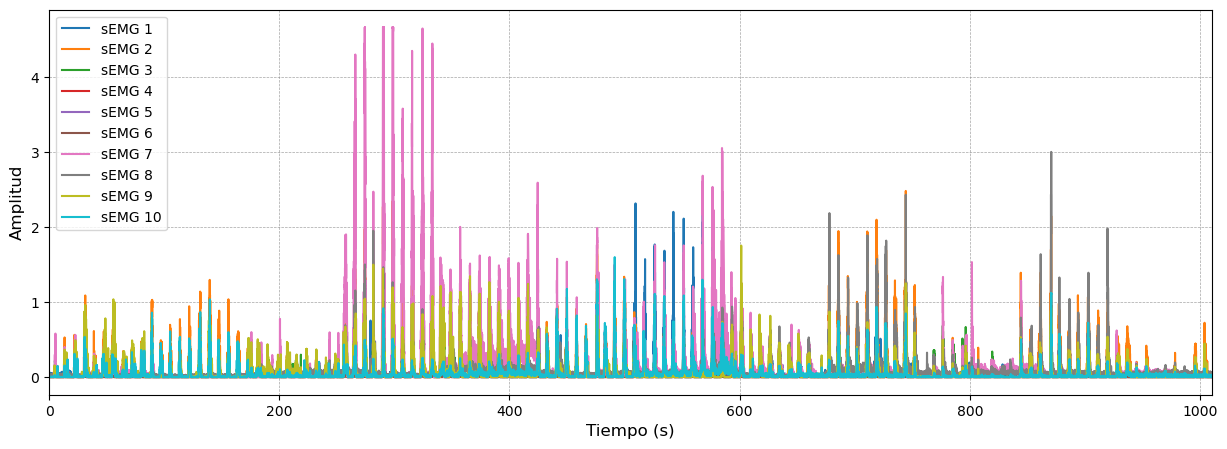

In [25]:
# Crear la figura y subgráficos
fig, ax = plt.subplots(figsize=(15, 5))
# print(emg_signals_s1)

for i in range(emg_signals_s1.shape[1]):
    ax.plot(timeEMG_s1, emg_signals_s1[:,i], label='sEMG ' + str(i+1))

# Agregar etiquetas de los ejes y título del gráfico
ax.set_xlabel('Tiempo (s)', fontsize=12)
ax.set_ylabel('Amplitud', fontsize=12)
# Configurar la cuadrícula con estilo personalizado
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Mostrar la leyenda para identificar cada serie de datos
ax.legend(loc='upper right')

# Mostrar la leyenda de líneas adicionales
ax.legend()

# Agregar una cuadrícula
ax.grid(True)

# Mostrar el gráfico
plt.xlim(min(timeEMG_s1),max(timeEMG_s1))
plt.show()

#### 4.1.2. Grafica completa de las señales del sujeto 1

Para dar un mayor contexto sobre la relación entre las señales asociadas a los electrodos sEMG con las repeticiones y las posturas llevadas a cabo por el sujeto al realizar el ejercicio 1 se muestra la siguiente grafica:

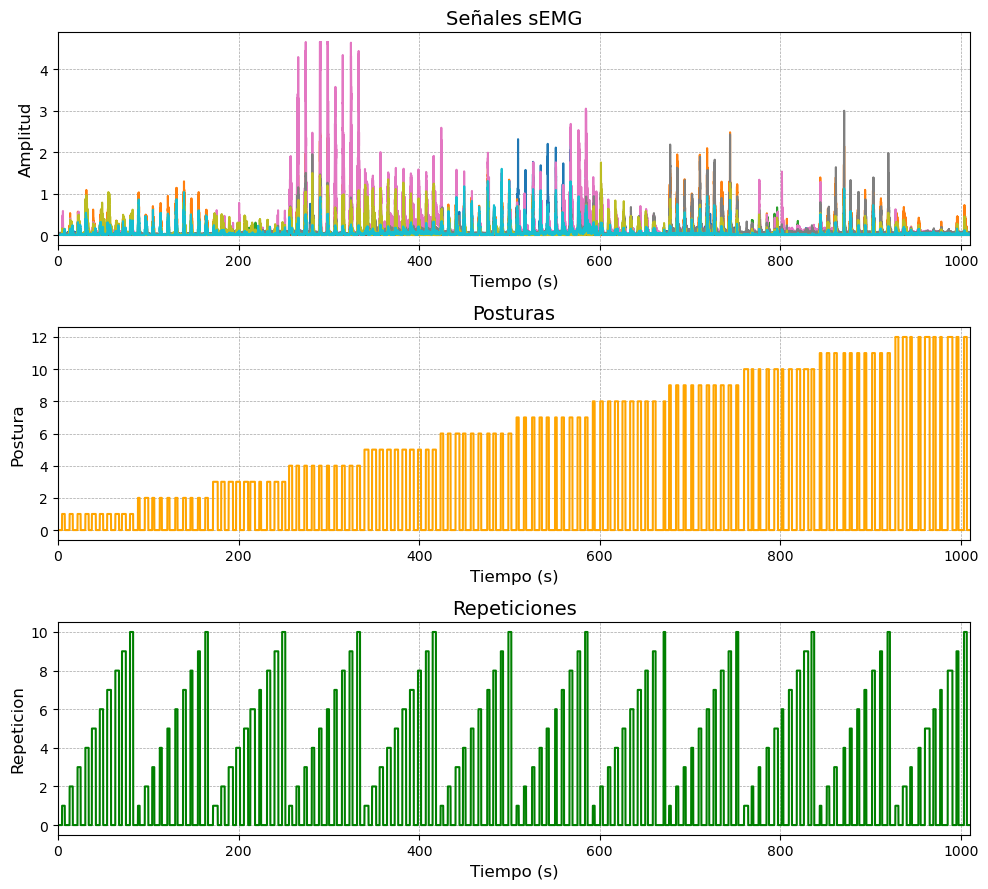

In [26]:
# Crear la figura y la cuadrícula de subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(3, 1, figsize=(10, 9))

# Gráfico 1: Señales sEMG
for i in range(emg_signals_s1.shape[1]):
    axs[0].plot(timeEMG_s1, emg_signals_s1[:,i])
axs[0].set_title('Señales sEMG', fontsize=14)
axs[0].set_xlabel('Tiempo (s)', fontsize=12)
axs[0].set_ylabel('Amplitud', fontsize=12)
axs[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axs[0].set_xlim(min(timeEMG_s1),max(timeEMG_s1))

# Gráfico 2: Postura
axs[1].plot(timeEMG_s1, posturas_s1, color='orange')
axs[1].set_title('Posturas', fontsize=14)
axs[1].set_xlabel('Tiempo (s)', fontsize=12)
axs[1].set_ylabel('Postura', fontsize=12)
axs[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axs[1].set_xlim(min(timeEMG_s1),max(timeEMG_s1))

# Gráfico 3: Repeticion
axs[2].plot(timeEMG_s1, repeticiones_s1, color='green')
axs[2].set_title('Repeticiones', fontsize=14)
axs[2].set_xlabel('Tiempo (s)', fontsize=12)
axs[2].set_ylabel('Repeticion', fontsize=12)
axs[2].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axs[2].set_xlim(min(timeEMG_s1),max(timeEMG_s1))

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico con subplots
plt.show()

De las graficas anteriores, es importante notar, que la captura mostrada tiene todos los ejercicios y todas las repeticiones. 

#### 4.1.3. Grafica de las señales sEMG de la postura 2 para el sujeto 1

En la siguiente figura se muestra la grafica de las señales sEMG para las 10 repeticiones llevadas a cabo cuando el sujeto esta realizando la postura 2. Notese que la grafica de abajo oscila entre 0 y 2 indicando la alternancia entre las posturas de descanso (0) y la postura (2) cuando se realizan la repeticiones.

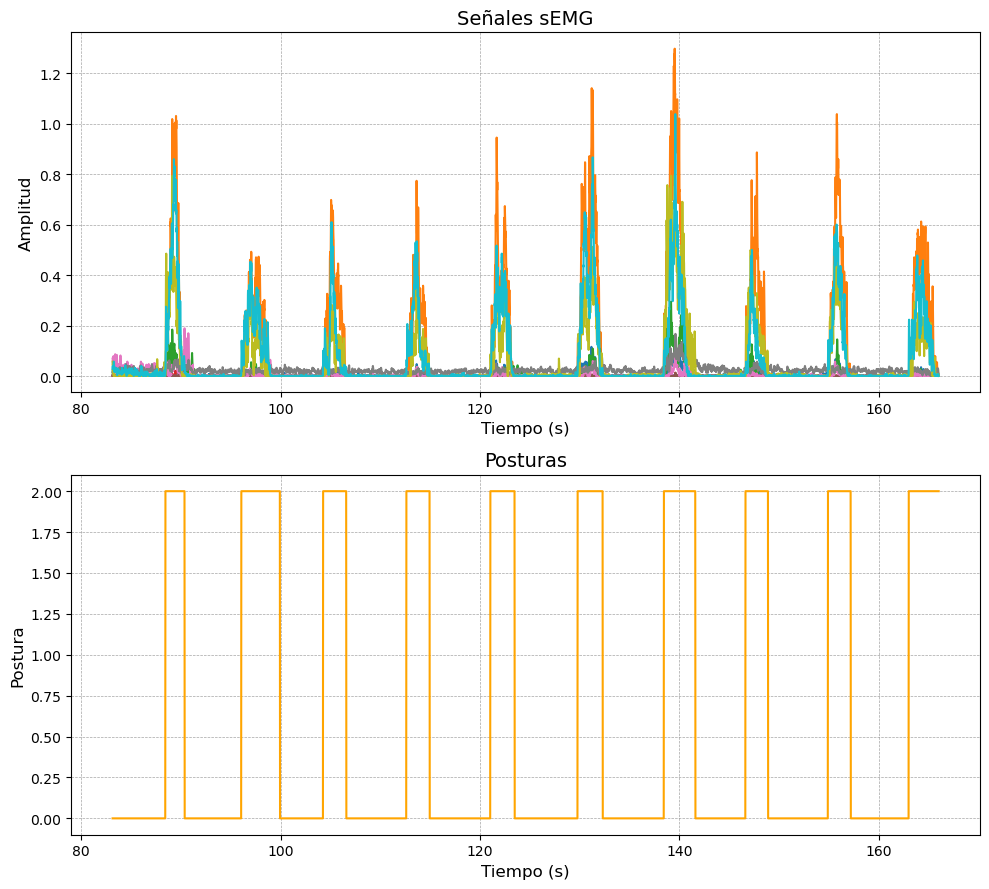

In [27]:
# Crear la figura y subgráficos
ind_post2 = indice_postura(posturas_s1,2)
start_index_post2 = ind_post2[0]
end_index_post2 = ind_post2[1]

timeEMG_post2 = timeEMG_s1[start_index_post2:end_index_post2 + 1] 
emgs_s1_post2 = emg_signals_s1[start_index_post2:end_index_post2 + 1,:]
label_s1_post2 = posturas_s1[start_index_post2:end_index_post2 + 1]

# Crear la figura y la cuadrícula de subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 1, figsize=(10, 9))

# Gráfico 1: Señale sEMG
for i in range(emgs_s1_post2.shape[1]):
    axs[0].plot(timeEMG_post2, emgs_s1_post2[:,i], label='sEMG ' + str(i+1))
axs[0].set_title('Señales sEMG', fontsize=14)
axs[0].set_xlabel('Tiempo (s)', fontsize=12)
axs[0].set_ylabel('Amplitud', fontsize=12)
axs[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#plt.xlim(min(timeEMG_post1),max(timeEMG_post1))


# Gráfico 2: Postura
axs[1].plot(timeEMG_post2, label_s1_post2, color='orange')
axs[1].set_title('Posturas', fontsize=14)
axs[1].set_xlabel('Tiempo (s)', fontsize=12)
axs[1].set_ylabel('Postura', fontsize=12)
axs[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#plt.xlim(min(timeEMG_post1),max(timeEMG_post1))

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico con subplots

plt.show()

### 4.2. Filtrado

En la figura anterior se puede notar que las señales de los sEMG contienen ruido por lo que es necesario realizar un Filtrado para eliminarlo. Para esto se emplea un filtro pasabajo con frecuencia de corte de 1 Hz. A continuación se describe el procedimiento completo.

#### 4.2.1. Definición del filtro

Mediante la función [`butter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) se define un filtro pasabajas Butterworth de orden 2 con frecuencia de corte de 1 Hz.

In [28]:
# Perform 2-order 1Hz low-pass filter
cutoff_freq = 1
nyquist = sample_freq/2
filter_order = 2
filter_type = 'lowpass'
normal_cutoff = cutoff_freq / nyquist
b, a = signal.butter(N = filter_order, 
                     Wn = normal_cutoff, 
                     btype = filter_type)

#### 4.2.2. Prueba del filtro

A continuación se va a probar el filtro previamente definido con la parte de la señal asociada a la postura 2 del sujeto 1 (graficada anteriormente). 

##### 4.2.2.1. Filtrado de la señal para la postura 2 del sujeto 1 (muestra)

Mediante la funcion [`filtfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html), se aplica el filtro anterior sobre cada una de las señales sEMG (columnas `emg_i`) asociadas a la postura 2 del sujeto 1, para remover el ruido.

In [29]:
# Filtrado de las señales sEMG
emgs_s1_post2_filter = signal.filtfilt(b, a, emgs_s1_post2, axis=0)

##### 4.2.2.2. Grafica de la señal filtrada para la postura 2

Se grafica la señal filtrada para verificar que el ruido ha sido eliminado.

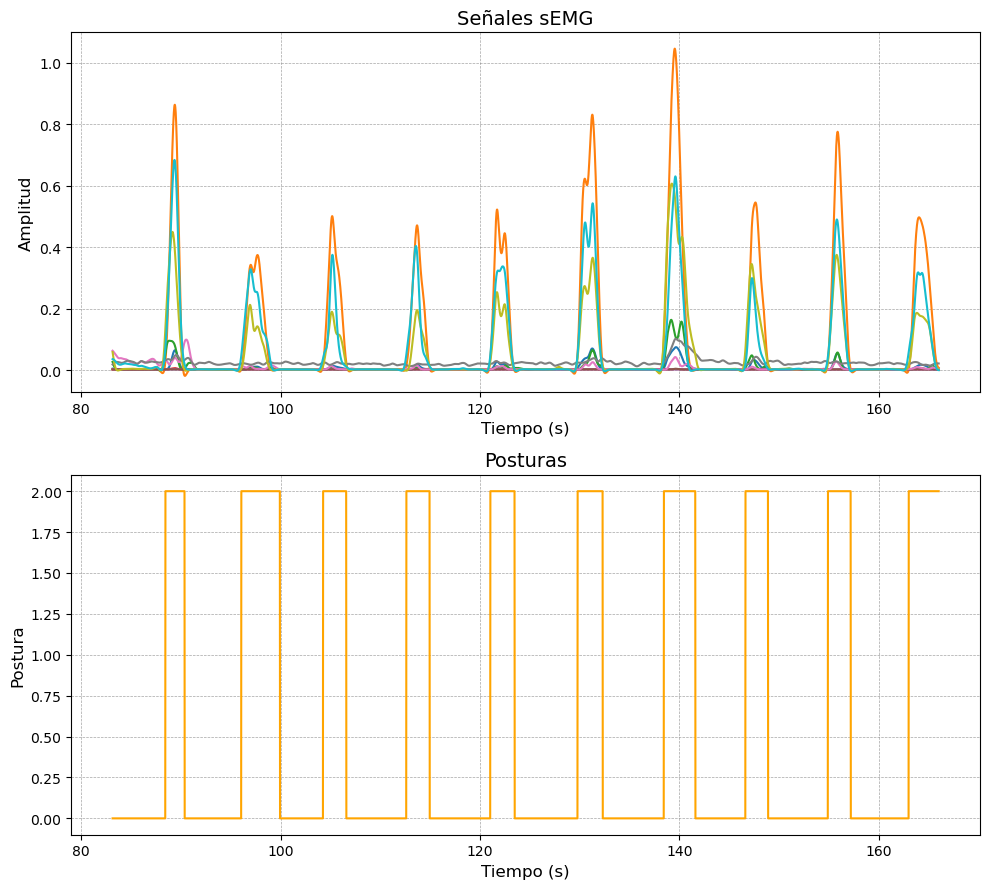

In [30]:
# Crear la figura y subgráficos

# Crear la figura y la cuadrícula de subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 1, figsize=(10, 9))

# Gráfico 1: sEMG
for i in range(emgs_s1_post2_filter.shape[1]):
    axs[0].plot(timeEMG_post2, emgs_s1_post2_filter[:,i], label='sEMG ' + str(i+1))
axs[0].set_title('Señales sEMG', fontsize=14)
axs[0].set_xlabel('Tiempo (s)', fontsize=12)
axs[0].set_ylabel('Amplitud', fontsize=12)
axs[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# plt.xlim(min(timeEMG_post2),max(timeEMG_post2))


# Gráfico 2: Postura
axs[1].plot(timeEMG_post2, label_s1_post2, color='orange')
axs[1].set_title('Posturas', fontsize=14)
axs[1].set_xlabel('Tiempo (s)', fontsize=12)
axs[1].set_ylabel('Postura', fontsize=12)
axs[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# plt.xlim(min(timeEMG_post2),max(timeEMG_post2))

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico con subplots

plt.show()

Como se puede notar, si se compara la grafica de la señal filtrada con su version no filtrada, la primera es mas limpia lo que sugiere que el filtro hizo su trabajo.

#### 4.2.3. Filtrado de la señal sEMG

Se replica el procedimiendo mostrado en la sección 3.2.2.1 aplicando el filtrado a todos los datos sEMG. Para empezar,  se muestran las primeras filas del dataframe sin filtrar:

In [31]:
# Primeras filas del dataframe sin filtrar
filter_df = raw_df.copy()
raw_df.head()

s   emg_1   emg_2   emg_3   emg_4   emg_5   emg_6   emg_7   emg_8   emg_9  \
0  1  0.0684  0.0024  0.0024  0.0024  0.0024  0.0098  0.0024  0.0488  0.0024   
1  1  0.0586  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0415  0.0024   
2  1  0.0562  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0391  0.0024   
3  1  0.0562  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024  0.0342  0.0024   
4  1  0.0488  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0366  0.0024   

   emg_10 rep label     t  
0  0.0342   0     0  0.00  
1  0.0293   0     0  0.01  
2  0.0244   0     0  0.02  
3  0.0171   0     0  0.03  
4  0.0146   0     0  0.04

Ahora se procede a filtrar cada una de las columnas de los valores de los sensores sEMG.

In [32]:
# Aplicando el filtrado en cada columna se tiene
emg_cols = ['emg_'+str(i) for i in range(1,11)]
for col in emg_cols:
    filter_df[col] = signal.filtfilt(b, a, filter_df[col], axis=0)

Los resultados del dataframe filtrado se muestra a continuación (note la diferencia de la porción del dataframe mostrado a continuación con su version previa sin filtrar):

In [33]:
filter_df.head()

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0  1  0.067523  0.002402  0.002399  0.002403  0.002395  0.009800  0.0024   
1  1  0.066284  0.002402  0.002402  0.002404  0.002395  0.009474  0.0024   
2  1  0.065045  0.002403  0.002405  0.002404  0.002395  0.009149  0.0024   
3  1  0.063810  0.002403  0.002409  0.002405  0.002395  0.008827  0.0024   
4  1  0.062581  0.002404  0.002412  0.002406  0.002395  0.008507  0.0024   

      emg_8   emg_9    emg_10 rep label     t  
0  0.050357  0.0024  0.034192   0     0  0.00  
1  0.049707  0.0024  0.032820   0     0  0.01  
2  0.049050  0.0024  0.031452   0     0  0.02  
3  0.048390  0.0024  0.030091   0     0  0.03  
4  0.047726  0.0024  0.028743   0     0  0.04

#### 4.2.4. Exploración basica del dataset filtrado

Aunque los datos aun no estan listos para pasar a los modelos, se quizo realizar una exploración básica de este dataset para tener una idea de como luce.

##### 4.2.4.1. Información basica del dataset

In [34]:
filter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 14 columns):
 #   Column  Dtype   
---  ------  -----   
 0   s       category
 1   emg_1   float64 
 2   emg_2   float64 
 3   emg_3   float64 
 4   emg_4   float64 
 5   emg_5   float64 
 6   emg_6   float64 
 7   emg_7   float64 
 8   emg_8   float64 
 9   emg_9   float64 
 10  emg_10  float64 
 11  rep     category
 12  label   category
 13  t       float64 
dtypes: category(3), float64(11)
memory usage: 237.0 MB


In [35]:
# Sujetos
filter_df['s'].value_counts().sort_index()

s
1     101014
2     100686
3     100720
4     100835
5     100894
6     101083
7     100817
8     100854
9     100925
10    100778
11    100899
12    100920
13    100948
14    100785
15    101508
16    101191
17    101675
18    101323
19    101299
20    101565
21    101732
22    101884
23    101221
24    101698
25    101549
26    101642
27    100948
Name: count, dtype: int64

Vemos que el numero de muestras por sujeto es aproximadamente el mismo como se puede corroborar en el siguiente grafico de barras.

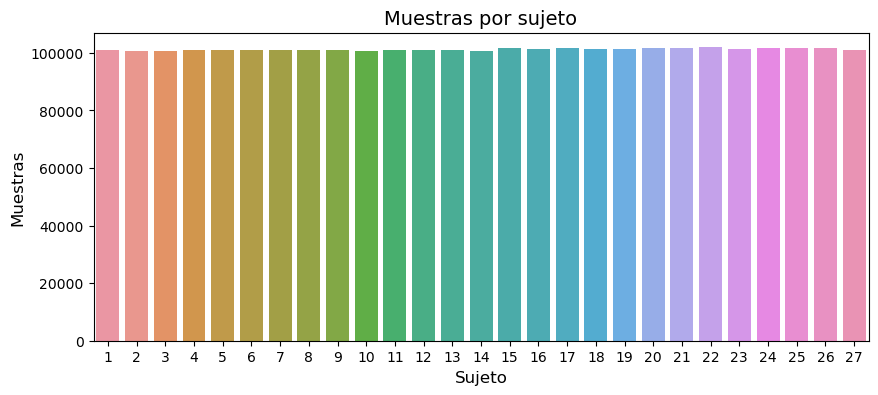

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x='s', data=filter_df)
ax.set_title('Muestras por sujeto', fontsize=14)
ax.set_xlabel('Sujeto', fontsize=12)
ax.set_ylabel('Muestras', fontsize=12)
plt.show()

En lo que respecta a la cantidad de repeticiones tenemos:

In [37]:
filter_df['rep'].value_counts().sort_index()

rep
0     1542153
1      122717
2      121490
3      120834
4      117230
5      118336
6      119118
7      116940
8      117748
9      117007
10     117820
Name: count, dtype: int64

Hay un total de 10 repeticiones (1 - 10); sin embargo, cuando el sujeto tiene la postura en la posición de descanso, el numero asociado a esta es 0. 

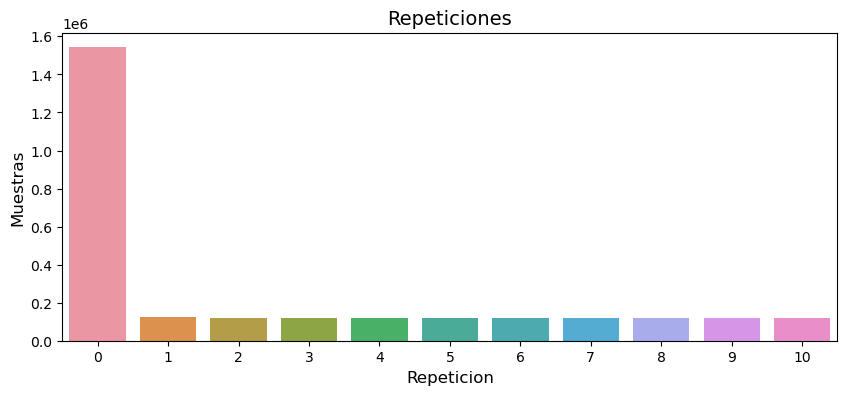

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x='rep', data=filter_df)
ax.set_title('Repeticiones', fontsize=14)
ax.set_xlabel('Repeticion', fontsize=12)
ax.set_ylabel('Muestras', fontsize=12)
plt.show()

Tal y como se muestra en la grafica anterior, la cantidad de muestras en la posición de descanso es dominante respecto a las muestras asociadas a las repeticiones.

Ahora veamos la cantidad de muestras asociadas a una postura, siendo 0 la postura asociada a la posición de descanso:

In [39]:
filter_df['label'].value_counts().sort_index()

label
0     1542153
1      102805
2      101570
3      113696
4       95109
5       95228
6       99451
7      100561
8      104325
9       95952
10      92413
11      88784
12      99346
Name: count, dtype: int64

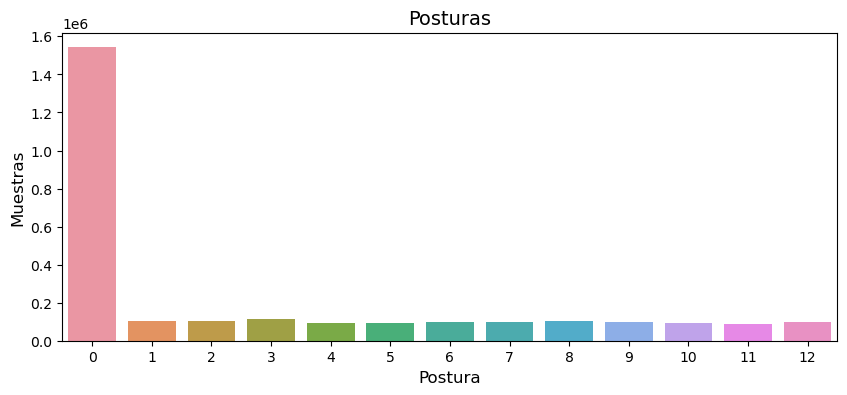

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x='label', data=filter_df)
ax.set_title('Posturas', fontsize=14)
ax.set_xlabel('Postura', fontsize=12)
ax.set_ylabel('Muestras', fontsize=12)
plt.show()

Vemos que la mayor cantidad de muestras se da para la pocisión de descanso (0) por lo cual esta es una postura dominante. A continuación se inspeccionan los tipos de datos de las columnas del dataset.

In [41]:
filter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 14 columns):
 #   Column  Dtype   
---  ------  -----   
 0   s       category
 1   emg_1   float64 
 2   emg_2   float64 
 3   emg_3   float64 
 4   emg_4   float64 
 5   emg_5   float64 
 6   emg_6   float64 
 7   emg_7   float64 
 8   emg_8   float64 
 9   emg_9   float64 
 10  emg_10  float64 
 11  rep     category
 12  label   category
 13  t       float64 
dtypes: category(3), float64(11)
memory usage: 237.0 MB


In [42]:
# Columnas
filter_df.columns

Index(['s', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7',
       'emg_8', 'emg_9', 'emg_10', 'rep', 'label', 't'],
      dtype='object')

In [43]:
# Completitud de los datos
filter_df.isna().sum()

s         0
emg_1     0
emg_2     0
emg_3     0
emg_4     0
emg_5     0
emg_6     0
emg_7     0
emg_8     0
emg_9     0
emg_10    0
rep       0
label     0
t         0
dtype: int64

Verificación de datos unicos

In [44]:
display(filter_df.nunique())
display(filter_df['s'].unique())
display(filter_df['rep'].unique())
display(filter_df['label'].unique())

s              27
emg_1     2731393
emg_2     2731189
emg_3     2731393
emg_4     2729274
emg_5     2731393
emg_6     2717121
emg_7     2731393
emg_8     2731393
emg_9     2728796
emg_10    2731393
rep            11
label          13
t         2731393
dtype: int64

[1, 2, 3, 4, 5, ..., 23, 24, 25, 26, 27]
Length: 27
Categories (27, int8): [1, 2, 3, 4, ..., 24, 25, 26, 27]

[0, 1, 2, 3, 4, ..., 6, 7, 8, 9, 10]
Length: 11
Categories (11, uint8): [0, 1, 2, 3, ..., 7, 8, 9, 10]

[0, 1, 2, 3, 4, ..., 8, 9, 10, 11, 12]
Length: 13
Categories (13, uint8): [0, 1, 2, 3, ..., 9, 10, 11, 12]

##### 4.2.4.2. Estadisticas resumen

A continuación sev muestra información estadistica de las variables asociadas a las señales sEMG.

In [45]:
# Señales sEMG
filter_df.columns[1:11]

Index(['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8',
       'emg_9', 'emg_10'],
      dtype='object')

In [46]:
# Despliegue de los datos de estadistica univariada
with pd.option_context('float_format', '{:f}'.format):
    display(filter_df.iloc[:,:-2].describe())

emg_1          emg_2          emg_3          emg_4  \
count 2731393.000000 2731393.000000 2731393.000000 2731393.000000   
mean        0.195195       0.122251       0.122080       0.042121   
std         0.320324       0.220754       0.302355       0.120017   
min        -0.050024      -0.048130      -0.115533      -0.043199   
25%         0.004995       0.002435       0.002538       0.002400   
50%         0.057786       0.016516       0.008818       0.002550   
75%         0.260736       0.148558       0.118000       0.022031   
max         4.772827       2.992637       4.799877       4.715544   

               emg_5          emg_6          emg_7          emg_8  \
count 2731393.000000 2731393.000000 2731393.000000 2731393.000000   
mean        0.011902       0.034457       0.303733       0.303680   
std         0.031780       0.089595       0.522617       0.366763   
min        -0.010148      -0.020428      -0.124056      -0.036300   
25%         0.002455       0.002403       0.023524       0.076280   
50%         0.002578       0.003350       0.130650       0.198724   
75%         0.004293       0.022775       0.360370       0.386994   
max         0.869776       1.902337       4.832991       4.480645   

               emg_9         emg_10  
count 2731393.000000 2731393.000000  
mean        0.117703       0.234548  
std         0.288361       0.341319  
min        -0.126998      -0.059506  
25%         0.002404       0.016688  
50%         0.006833       0.118852  
75%         0.099222       0.306058  
max         4.826315       4.322086

##### 4.2.4.3. Matriz de correlación

Para obtener la correlacion vamos a volver el label numerico (de nuevo)

In [47]:
filter_df['label'] = filter_df['label'].astype('uint8')
# Calculate the correlation matrix
correlation_matrix = filter_df[['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8','emg_9', 'emg_10','label']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


emg_1     emg_2     emg_3     emg_4     emg_5     emg_6     emg_7  \
emg_1   1.000000  0.453761  0.326322  0.280480  0.382454  0.176835  0.191175   
emg_2   0.453761  1.000000  0.451567  0.381319  0.548464  0.419069  0.480181   
emg_3   0.326322  0.451567  1.000000  0.510592  0.453392  0.206657  0.307099   
emg_4   0.280480  0.381319  0.510592  1.000000  0.670789  0.249064  0.280444   
emg_5   0.382454  0.548464  0.453392  0.670789  1.000000  0.641675  0.609626   
emg_6   0.176835  0.419069  0.206657  0.249064  0.641675  1.000000  0.681425   
emg_7   0.191175  0.480181  0.307099  0.280444  0.609626  0.681425  1.000000   
emg_8   0.340444  0.418293  0.377289  0.381770  0.477803  0.334104  0.446624   
emg_9   0.311100  0.496885  0.601478  0.482089  0.476647  0.293283  0.372298   
emg_10  0.293134  0.457090  0.405319  0.410729  0.501956  0.450019  0.571753   
label   0.297431  0.285061  0.279396  0.269300  0.220875  0.165580  0.166338   

           emg_8     emg_9    emg_10     label  
emg_1   0.340444  0.311100  0.293134  0.297431  
emg_2   0.418293  0.496885  0.457090  0.285061  
emg_3   0.377289  0.601478  0.405319  0.279396  
emg_4   0.381770  0.482089  0.410729  0.269300  
emg_5   0.477803  0.476647  0.501956  0.220875  
emg_6   0.334104  0.293283  0.450019  0.165580  
emg_7   0.446624  0.372298  0.571753  0.166338  
emg_8   1.000000  0.318840  0.537299  0.346617  
emg_9   0.318840  1.000000  0.388849  0.265918  
emg_10  0.537299  0.388849  1.000000  0.287247  
label   0.346617  0.265918  0.287247  1.000000

La grafica de la matriz correlación se muestra a continuación:

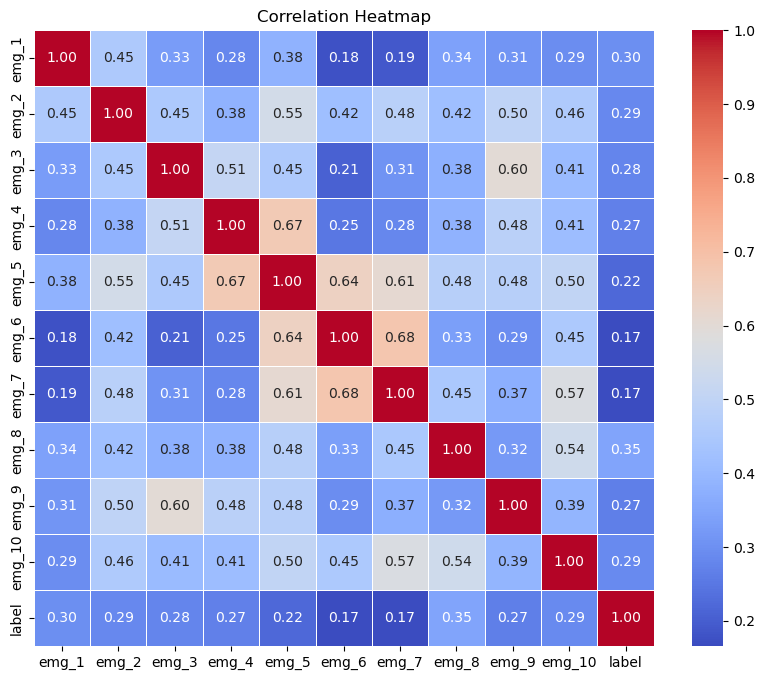

In [48]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

##### 4.2.4.4. Eliminación de columnas no necesarias

In [49]:
# Se elimina la columna del tiempo
filter_df = filter_df.drop(['t'], axis=1)
filter_df.head()

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0  1  0.067523  0.002402  0.002399  0.002403  0.002395  0.009800  0.0024   
1  1  0.066284  0.002402  0.002402  0.002404  0.002395  0.009474  0.0024   
2  1  0.065045  0.002403  0.002405  0.002404  0.002395  0.009149  0.0024   
3  1  0.063810  0.002403  0.002409  0.002405  0.002395  0.008827  0.0024   
4  1  0.062581  0.002404  0.002412  0.002406  0.002395  0.008507  0.0024   

      emg_8   emg_9    emg_10 rep  label  
0  0.050357  0.0024  0.034192   0      0  
1  0.049707  0.0024  0.032820   0      0  
2  0.049050  0.0024  0.031452   0      0  
3  0.048390  0.0024  0.030091   0      0  
4  0.047726  0.0024  0.028743   0      0

## 5. Extracción de caracteristicas

### 5.1. Segmentacion de la señal

La segmentación consiste en extraer porciones de la señal mediante ventanas de tiempo (que pueden ir sobrelapadas o no) para realizar una analisis local mas focalizado. La siguiente figura resume el procedimiento:

![overlap_window](overlap_window.png)

Para nuestro caso, vamos a seleccionar solamente los datos de los primeros 10 sujetos (de los 27 que hay en total). Luego, segmentamos estos datos en ventanas de tamaño 30 con un solapamiento de 10 y almacenamos estos segmentos en una lista.

In [50]:
filter_df.head()

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0  1  0.067523  0.002402  0.002399  0.002403  0.002395  0.009800  0.0024   
1  1  0.066284  0.002402  0.002402  0.002404  0.002395  0.009474  0.0024   
2  1  0.065045  0.002403  0.002405  0.002404  0.002395  0.009149  0.0024   
3  1  0.063810  0.002403  0.002409  0.002405  0.002395  0.008827  0.0024   
4  1  0.062581  0.002404  0.002412  0.002406  0.002395  0.008507  0.0024   

      emg_8   emg_9    emg_10 rep  label  
0  0.050357  0.0024  0.034192   0      0  
1  0.049707  0.0024  0.032820   0      0  
2  0.049050  0.0024  0.031452   0      0  
3  0.048390  0.0024  0.030091   0      0  
4  0.047726  0.0024  0.028743   0      0

In [51]:
# Determinacion del numero de sujetos a emplear para definir los datos que van al modelo
numero_de_sujetos = 10
w_size = 30
o_size = 10
if pd.api.types.is_categorical_dtype(filter_df['s']):
    filter_df['s'] = filter_df['s'].astype('uint8')
    
sujetos_muestra = filter_df[filter_df['s'] <= numero_de_sujetos]


segments = segmentar_data_set(data_set = sujetos_muestra, 
                              window_size = w_size, 
                              overlap_size = o_size)

Ahora vamos a verificar por encima que la segmentacion se haya realizado como se espera.

```
data_set --> [ window_0, window_1, window_2, ... window_n]  
         --> [ data_set[0:29], 
               data_set[20:49], 
               data_set[40:69], ...
             ]
```

Es importante tener en cuenta, es importante resaltar que aquellos segmentos en los cuales hay una transición (cambio en el label por ejemplo) son descartados de modo que no es de estrañar que hayan menos segmentos que el resultado teorico experado.

In [52]:
filter_df.head(50)

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0   1  0.067523  0.002402  0.002399  0.002403  0.002395  0.009800  0.0024   
1   1  0.066284  0.002402  0.002402  0.002404  0.002395  0.009474  0.0024   
2   1  0.065045  0.002403  0.002405  0.002404  0.002395  0.009149  0.0024   
3   1  0.063810  0.002403  0.002409  0.002405  0.002395  0.008827  0.0024   
4   1  0.062581  0.002404  0.002412  0.002406  0.002395  0.008507  0.0024   
5   1  0.061362  0.002404  0.002415  0.002407  0.002395  0.008192  0.0024   
6   1  0.060156  0.002405  0.002419  0.002407  0.002396  0.007881  0.0024   
7   1  0.058966  0.002406  0.002422  0.002408  0.002396  0.007576  0.0024   
8   1  0.057793  0.002406  0.002425  0.002409  0.002396  0.007278  0.0024   
9   1  0.056641  0.002407  0.002428  0.002410  0.002396  0.006986  0.0024   
10  1  0.055512  0.002408  0.002432  0.002411  0.002396  0.006702  0.0024   
11  1  0.054407  0.002409  0.002435  0.002412  0.002397  0.006426  0.0024   
12  1  0.053328  0.002410  0.002438  0.002413  0.002397  0.006158  0.0024   
13  1  0.052277  0.002411  0.002440  0.002414  0.002398  0.005899  0.0024   
14  1  0.051255  0.002412  0.002443  0.002415  0.002398  0.005648  0.0024   
15  1  0.050263  0.002413  0.002446  0.002417  0.002399  0.005407  0.0024   
16  1  0.049303  0.002414  0.002449  0.002418  0.002399  0.005175  0.0024   
17  1  0.048374  0.002415  0.002452  0.002419  0.002400  0.004952  0.0024   
18  1  0.047478  0.002416  0.002455  0.002420  0.002400  0.004738  0.0024   
19  1  0.046615  0.002418  0.002458  0.002422  0.002401  0.004533  0.0024   
20  1  0.045784  0.002419  0.002461  0.002423  0.002402  0.004338  0.0024   
21  1  0.044986  0.002420  0.002464  0.002425  0.002403  0.004152  0.0024   
22  1  0.044221  0.002422  0.002467  0.002426  0.002404  0.003976  0.0024   
23  1  0.043488  0.002423  0.002470  0.002428  0.002405  0.003808  0.0024   
24  1  0.042789  0.002425  0.002474  0.002429  0.002406  0.003649  0.0024   
25  1  0.042121  0.002426  0.002477  0.002431  0.002407  0.003500  0.0024   
26  1  0.041485  0.002428  0.002480  0.002432  0.002408  0.003358  0.0024   
27  1  0.040880  0.002429  0.002484  0.002434  0.002410  0.003225  0.0024   
28  1  0.040305  0.002431  0.002487  0.002435  0.002411  0.003100  0.0024   
29  1  0.039760  0.002432  0.002491  0.002437  0.002413  0.002984  0.0024   
30  1  0.039245  0.002434  0.002495  0.002439  0.002414  0.002874  0.0024   
31  1  0.038759  0.002435  0.002498  0.002440  0.002416  0.002773  0.0024   
32  1  0.038302  0.002437  0.002502  0.002442  0.002418  0.002678  0.0024   
33  1  0.037875  0.002439  0.002506  0.002443  0.002420  0.002591  0.0024   
34  1  0.037477  0.002440  0.002510  0.002445  0.002422  0.002510  0.0024   
35  1  0.037110  0.002442  0.002514  0.002446  0.002424  0.002436  0.0024   
36  1  0.036773  0.002443  0.002518  0.002448  0.002426  0.002368  0.0024   
37  1  0.036466  0.002445  0.002522  0.002449  0.002428  0.002305  0.0024   
38  1  0.036190  0.002446  0.002526  0.002450  0.002430  0.002249  0.0024   
39  1  0.035944  0.002448  0.002530  0.002451  0.002433  0.002197  0.0024   
40  1  0.035728  0.002449  0.002534  0.002452  0.002435  0.002151  0.0024   
41  1  0.035540  0.002450  0.002538  0.002453  0.002438  0.002110  0.0024   
42  1  0.035379  0.002451  0.002542  0.002454  0.002440  0.002073  0.0024   
43  1  0.035246  0.002452  0.002546  0.002455  0.002443  0.002041  0.0024   
44  1  0.035139  0.002453  0.002549  0.002455  0.002446  0.002013  0.0024   
45  1  0.035058  0.002454  0.002553  0.002455  0.002449  0.001988  0.0024   
46  1  0.035000  0.002455  0.002556  0.002456  0.002452  0.001967  0.0024   
47  1  0.034966  0.002455  0.002559  0.002455  0.002455  0.001950  0.0024   
48  1  0.034954  0.002456  0.002562  0.002455  0.002458  0.001936  0.0024   
49  1  0.034961  0.002456  0.002564  0.002455  0.002461  0.001924  0.0024   

       emg_8   emg_9    emg_10 rep  label  
0   0.050357  0.0024  0.034192  

Veamos los dos primeros segmentos

In [53]:
segments[0]

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0   1  0.067523  0.002402  0.002399  0.002403  0.002395  0.009800  0.0024   
1   1  0.066284  0.002402  0.002402  0.002404  0.002395  0.009474  0.0024   
2   1  0.065045  0.002403  0.002405  0.002404  0.002395  0.009149  0.0024   
3   1  0.063810  0.002403  0.002409  0.002405  0.002395  0.008827  0.0024   
4   1  0.062581  0.002404  0.002412  0.002406  0.002395  0.008507  0.0024   
5   1  0.061362  0.002404  0.002415  0.002407  0.002395  0.008192  0.0024   
6   1  0.060156  0.002405  0.002419  0.002407  0.002396  0.007881  0.0024   
7   1  0.058966  0.002406  0.002422  0.002408  0.002396  0.007576  0.0024   
8   1  0.057793  0.002406  0.002425  0.002409  0.002396  0.007278  0.0024   
9   1  0.056641  0.002407  0.002428  0.002410  0.002396  0.006986  0.0024   
10  1  0.055512  0.002408  0.002432  0.002411  0.002396  0.006702  0.0024   
11  1  0.054407  0.002409  0.002435  0.002412  0.002397  0.006426  0.0024   
12  1  0.053328  0.002410  0.002438  0.002413  0.002397  0.006158  0.0024   
13  1  0.052277  0.002411  0.002440  0.002414  0.002398  0.005899  0.0024   
14  1  0.051255  0.002412  0.002443  0.002415  0.002398  0.005648  0.0024   
15  1  0.050263  0.002413  0.002446  0.002417  0.002399  0.005407  0.0024   
16  1  0.049303  0.002414  0.002449  0.002418  0.002399  0.005175  0.0024   
17  1  0.048374  0.002415  0.002452  0.002419  0.002400  0.004952  0.0024   
18  1  0.047478  0.002416  0.002455  0.002420  0.002400  0.004738  0.0024   
19  1  0.046615  0.002418  0.002458  0.002422  0.002401  0.004533  0.0024   
20  1  0.045784  0.002419  0.002461  0.002423  0.002402  0.004338  0.0024   
21  1  0.044986  0.002420  0.002464  0.002425  0.002403  0.004152  0.0024   
22  1  0.044221  0.002422  0.002467  0.002426  0.002404  0.003976  0.0024   
23  1  0.043488  0.002423  0.002470  0.002428  0.002405  0.003808  0.0024   
24  1  0.042789  0.002425  0.002474  0.002429  0.002406  0.003649  0.0024   
25  1  0.042121  0.002426  0.002477  0.002431  0.002407  0.003500  0.0024   
26  1  0.041485  0.002428  0.002480  0.002432  0.002408  0.003358  0.0024   
27  1  0.040880  0.002429  0.002484  0.002434  0.002410  0.003225  0.0024   
28  1  0.040305  0.002431  0.002487  0.002435  0.002411  0.003100  0.0024   
29  1  0.039760  0.002432  0.002491  0.002437  0.002413  0.002984  0.0024   

       emg_8   emg_9    emg_10 rep  label  
0   0.050357  0.0024  0.034192   0      0  
1   0.049707  0.0024  0.032820   0      0  
2   0.049050  0.0024  0.031452   0      0  
3   0.048390  0.0024  0.030091   0      0  
4   0.047726  0.0024  0.028743   0      0  
5   0.047061  0.0024  0.027410   0      0  
6   0.046395  0.0024  0.026096   0      0  
7   0.045729  0.0024  0.024805   0      0  
8   0.045064  0.0024  0.023539   0      0  
9   0.044399  0.0024  0.022300   0      0  
10  0.043736  0.0024  0.021092   0      0  
11  0.043073  0.0024  0.019916   0      0  
12  0.042413  0.0024  0.018774   0      0  
13  0.041753  0.0024  0.017668   0      0  
14  0.041094  0.0024  0.016597   0      0  
15  0.040437  0.0024  0.015565   0      0  
16  0.039781  0.0024  0.014570   0      0  
17  0.039126  0.0024  0.013614   0      0  
18  0.038473  0.0024  0.012698   0      0  
19  0.037821  0.0024  0.011820   0      0  
20  0.037171  0.0024  0.010982   0      0  
21  0.036524  0.0024  0.010183   0      0  
22  0.035881  0.0024  0.009423   0      0  
23  0.035243  0.0024  0.008701   0      0  
24  0.034611  0.0024  0.008017   0      0  
25  0.033986  0.0024  0.007370   0      0  
26  0.033369  0.0024  0.006760   0      0  
27  0.032763  0.0024  0.006185   0      0  
28  0.032168  0.0024  0.005646   0      0  
29  0.031586  0.0024  0.005140   0      0

In [54]:
segments[1]

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0   1  0.045784  0.002419  0.002461  0.002423  0.002402  0.004338  0.0024   
1   1  0.044986  0.002420  0.002464  0.002425  0.002403  0.004152  0.0024   
2   1  0.044221  0.002422  0.002467  0.002426  0.002404  0.003976  0.0024   
3   1  0.043488  0.002423  0.002470  0.002428  0.002405  0.003808  0.0024   
4   1  0.042789  0.002425  0.002474  0.002429  0.002406  0.003649  0.0024   
5   1  0.042121  0.002426  0.002477  0.002431  0.002407  0.003500  0.0024   
6   1  0.041485  0.002428  0.002480  0.002432  0.002408  0.003358  0.0024   
7   1  0.040880  0.002429  0.002484  0.002434  0.002410  0.003225  0.0024   
8   1  0.040305  0.002431  0.002487  0.002435  0.002411  0.003100  0.0024   
9   1  0.039760  0.002432  0.002491  0.002437  0.002413  0.002984  0.0024   
10  1  0.039245  0.002434  0.002495  0.002439  0.002414  0.002874  0.0024   
11  1  0.038759  0.002435  0.002498  0.002440  0.002416  0.002773  0.0024   
12  1  0.038302  0.002437  0.002502  0.002442  0.002418  0.002678  0.0024   
13  1  0.037875  0.002439  0.002506  0.002443  0.002420  0.002591  0.0024   
14  1  0.037477  0.002440  0.002510  0.002445  0.002422  0.002510  0.0024   
15  1  0.037110  0.002442  0.002514  0.002446  0.002424  0.002436  0.0024   
16  1  0.036773  0.002443  0.002518  0.002448  0.002426  0.002368  0.0024   
17  1  0.036466  0.002445  0.002522  0.002449  0.002428  0.002305  0.0024   
18  1  0.036190  0.002446  0.002526  0.002450  0.002430  0.002249  0.0024   
19  1  0.035944  0.002448  0.002530  0.002451  0.002433  0.002197  0.0024   
20  1  0.035728  0.002449  0.002534  0.002452  0.002435  0.002151  0.0024   
21  1  0.035540  0.002450  0.002538  0.002453  0.002438  0.002110  0.0024   
22  1  0.035379  0.002451  0.002542  0.002454  0.002440  0.002073  0.0024   
23  1  0.035246  0.002452  0.002546  0.002455  0.002443  0.002041  0.0024   
24  1  0.035139  0.002453  0.002549  0.002455  0.002446  0.002013  0.0024   
25  1  0.035058  0.002454  0.002553  0.002455  0.002449  0.001988  0.0024   
26  1  0.035000  0.002455  0.002556  0.002456  0.002452  0.001967  0.0024   
27  1  0.034966  0.002455  0.002559  0.002455  0.002455  0.001950  0.0024   
28  1  0.034954  0.002456  0.002562  0.002455  0.002458  0.001936  0.0024   
29  1  0.034961  0.002456  0.002564  0.002455  0.002461  0.001924  0.0024   

       emg_8   emg_9    emg_10 rep  label  
0   0.037171  0.0024  0.010982   0      0  
1   0.036524  0.0024  0.010183   0      0  
2   0.035881  0.0024  0.009423   0      0  
3   0.035243  0.0024  0.008701   0      0  
4   0.034611  0.0024  0.008017   0      0  
5   0.033986  0.0024  0.007370   0      0  
6   0.033369  0.0024  0.006760   0      0  
7   0.032763  0.0024  0.006185   0      0  
8   0.032168  0.0024  0.005646   0      0  
9   0.031586  0.0024  0.005140   0      0  
10  0.031020  0.0024  0.004668   0      0  
11  0.030470  0.0024  0.004228   0      0  
12  0.029938  0.0024  0.003818   0      0  
13  0.029426  0.0024  0.003439   0      0  
14  0.028935  0.0024  0.003088   0      0  
15  0.028468  0.0024  0.002766   0      0  
16  0.028024  0.0024  0.002470   0      0  
17  0.027606  0.0024  0.002199   0      0  
18  0.027215  0.0024  0.001953   0      0  
19  0.026851  0.0024  0.001730   0      0  
20  0.026515  0.0024  0.001529   0      0  
21  0.026208  0.0024  0.001349   0      0  
22  0.025930  0.0024  0.001190   0      0  
23  0.025682  0.0024  0.001049   0      0  
24  0.025462  0.0024  0.000926   0      0  
25  0.025271  0.0024  0.000820   0      0  
26  0.025109  0.0024  0.000730   0      0  
27  0.024974  0.0024  0.000654   0      0  
28  0.024865  0.0024  0.000592   0      0  
29  0.024782  0.0024  0.000544   0      0

En lo que respecta al tercer segmento, primero extraigamos los elementos del dataframe que deberian hacer parte de este.

In [55]:
filter_df.iloc[40:70]

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
40  1  0.035728  0.002449  0.002534  0.002452  0.002435  0.002151  0.0024   
41  1  0.035540  0.002450  0.002538  0.002453  0.002438  0.002110  0.0024   
42  1  0.035379  0.002451  0.002542  0.002454  0.002440  0.002073  0.0024   
43  1  0.035246  0.002452  0.002546  0.002455  0.002443  0.002041  0.0024   
44  1  0.035139  0.002453  0.002549  0.002455  0.002446  0.002013  0.0024   
45  1  0.035058  0.002454  0.002553  0.002455  0.002449  0.001988  0.0024   
46  1  0.035000  0.002455  0.002556  0.002456  0.002452  0.001967  0.0024   
47  1  0.034966  0.002455  0.002559  0.002455  0.002455  0.001950  0.0024   
48  1  0.034954  0.002456  0.002562  0.002455  0.002458  0.001936  0.0024   
49  1  0.034961  0.002456  0.002564  0.002455  0.002461  0.001924  0.0024   
50  1  0.034986  0.002456  0.002567  0.002454  0.002464  0.001916  0.0024   
51  1  0.035027  0.002455  0.002569  0.002453  0.002468  0.001910  0.0024   
52  1  0.035083  0.002455  0.002571  0.002452  0.002471  0.001906  0.0024   
53  1  0.035150  0.002454  0.002572  0.002451  0.002474  0.001904  0.0024   
54  1  0.035229  0.002453  0.002573  0.002450  0.002477  0.001905  0.0024   
55  1  0.035318  0.002452  0.002574  0.002449  0.002481  0.001907  0.0024   
56  1  0.035417  0.002451  0.002575  0.002447  0.002484  0.001911  0.0024   
57  1  0.035523  0.002450  0.002576  0.002446  0.002487  0.001916  0.0024   
58  1  0.035636  0.002449  0.002576  0.002445  0.002490  0.001923  0.0024   
59  1  0.035756  0.002448  0.002576  0.002443  0.002493  0.001931  0.0024   
60  1  0.035880  0.002446  0.002575  0.002442  0.002496  0.001940  0.0024   
61  1  0.036008  0.002445  0.002575  0.002440  0.002499  0.001950  0.0024   
62  1  0.036138  0.002443  0.002574  0.002438  0.002501  0.001961  0.0024   
63  1  0.036269  0.002442  0.002573  0.002437  0.002504  0.001972  0.0024   
64  1  0.036400  0.002440  0.002572  0.002435  0.002506  0.001985  0.0024   
65  1  0.036531  0.002439  0.002570  0.002434  0.002509  0.001997  0.0024   
66  1  0.036659  0.002437  0.002568  0.002432  0.002511  0.002011  0.0024   
67  1  0.036785  0.002435  0.002566  0.002430  0.002513  0.002024  0.0024   
68  1  0.036905  0.002434  0.002564  0.002429  0.002516  0.002038  0.0024   
69  1  0.037020  0.002432  0.002562  0.002427  0.002518  0.002052  0.0024   

       emg_8   emg_9    emg_10 rep  label  
40  0.026515  0.0024  0.001529   0      0  
41  0.026208  0.0024  0.001349   0      0  
42  0.025930  0.0024  0.001190   0      0  
43  0.025682  0.0024  0.001049   0      0  
44  0.025462  0.0024  0.000926   0      0  
45  0.025271  0.0024  0.000820   0      0  
46  0.025109  0.0024  0.000730   0      0  
47  0.024974  0.0024  0.000654   0      0  
48  0.024865  0.0024  0.000592   0      0  
49  0.024782  0.0024  0.000544   0      0  
50  0.024723  0.0024  0.000507   0      0  
51  0.024687  0.0024  0.000481   0      0  
52  0.024672  0.0024  0.000466   0      0  
53  0.024677  0.0024  0.000460   0      0  
54  0.024700  0.0024  0.000463   0      0  
55  0.024740  0.0024  0.000474   0      0  
56  0.024794  0.0024  0.000492   0      0  
57  0.024861  0.0024  0.000516   0      0  
58  0.024938  0.0024  0.000547   0      0  
59  0.025025  0.0024  0.000582   0      0  
60  0.025119  0.0024  0.000622   0      0  
61  0.025219  0.0024  0.000666   0      0  
62  0.025323  0.0024  0.000714   0      0  
63  0.025429  0.0024  0.000765   0      0  
64  0.025536  0.0024  0.000818   0      0  
65  0.025642  0.0024  0.000873   0      0  
66  0.025747  0.0024  0.000929   0      0  
67  0.025848  0.0024  0.000987   0      0  
68  0.025945  0.0024  0.001046   0      0  
69  0.026038  0.0024  0.001106   0      0

Ahora miremos el tercer segmento:

In [56]:
segments[2]

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0   1  0.035728  0.002449  0.002534  0.002452  0.002435  0.002151  0.0024   
1   1  0.035540  0.002450  0.002538  0.002453  0.002438  0.002110  0.0024   
2   1  0.035379  0.002451  0.002542  0.002454  0.002440  0.002073  0.0024   
3   1  0.035246  0.002452  0.002546  0.002455  0.002443  0.002041  0.0024   
4   1  0.035139  0.002453  0.002549  0.002455  0.002446  0.002013  0.0024   
5   1  0.035058  0.002454  0.002553  0.002455  0.002449  0.001988  0.0024   
6   1  0.035000  0.002455  0.002556  0.002456  0.002452  0.001967  0.0024   
7   1  0.034966  0.002455  0.002559  0.002455  0.002455  0.001950  0.0024   
8   1  0.034954  0.002456  0.002562  0.002455  0.002458  0.001936  0.0024   
9   1  0.034961  0.002456  0.002564  0.002455  0.002461  0.001924  0.0024   
10  1  0.034986  0.002456  0.002567  0.002454  0.002464  0.001916  0.0024   
11  1  0.035027  0.002455  0.002569  0.002453  0.002468  0.001910  0.0024   
12  1  0.035083  0.002455  0.002571  0.002452  0.002471  0.001906  0.0024   
13  1  0.035150  0.002454  0.002572  0.002451  0.002474  0.001904  0.0024   
14  1  0.035229  0.002453  0.002573  0.002450  0.002477  0.001905  0.0024   
15  1  0.035318  0.002452  0.002574  0.002449  0.002481  0.001907  0.0024   
16  1  0.035417  0.002451  0.002575  0.002447  0.002484  0.001911  0.0024   
17  1  0.035523  0.002450  0.002576  0.002446  0.002487  0.001916  0.0024   
18  1  0.035636  0.002449  0.002576  0.002445  0.002490  0.001923  0.0024   
19  1  0.035756  0.002448  0.002576  0.002443  0.002493  0.001931  0.0024   
20  1  0.035880  0.002446  0.002575  0.002442  0.002496  0.001940  0.0024   
21  1  0.036008  0.002445  0.002575  0.002440  0.002499  0.001950  0.0024   
22  1  0.036138  0.002443  0.002574  0.002438  0.002501  0.001961  0.0024   
23  1  0.036269  0.002442  0.002573  0.002437  0.002504  0.001972  0.0024   
24  1  0.036400  0.002440  0.002572  0.002435  0.002506  0.001985  0.0024   
25  1  0.036531  0.002439  0.002570  0.002434  0.002509  0.001997  0.0024   
26  1  0.036659  0.002437  0.002568  0.002432  0.002511  0.002011  0.0024   
27  1  0.036785  0.002435  0.002566  0.002430  0.002513  0.002024  0.0024   
28  1  0.036905  0.002434  0.002564  0.002429  0.002516  0.002038  0.0024   
29  1  0.037020  0.002432  0.002562  0.002427  0.002518  0.002052  0.0024   

       emg_8   emg_9    emg_10 rep  label  
0   0.026515  0.0024  0.001529   0      0  
1   0.026208  0.0024  0.001349   0      0  
2   0.025930  0.0024  0.001190   0      0  
3   0.025682  0.0024  0.001049   0      0  
4   0.025462  0.0024  0.000926   0      0  
5   0.025271  0.0024  0.000820   0      0  
6   0.025109  0.0024  0.000730   0      0  
7   0.024974  0.0024  0.000654   0      0  
8   0.024865  0.0024  0.000592   0      0  
9   0.024782  0.0024  0.000544   0      0  
10  0.024723  0.0024  0.000507   0      0  
11  0.024687  0.0024  0.000481   0      0  
12  0.024672  0.0024  0.000466   0      0  
13  0.024677  0.0024  0.000460   0      0  
14  0.024700  0.0024  0.000463   0      0  
15  0.024740  0.0024  0.000474   0      0  
16  0.024794  0.0024  0.000492   0      0  
17  0.024861  0.0024  0.000516   0      0  
18  0.024938  0.0024  0.000547   0      0  
19  0.025025  0.0024  0.000582   0      0  
20  0.025119  0.0024  0.000622   0      0  
21  0.025219  0.0024  0.000666   0      0  
22  0.025323  0.0024  0.000714   0      0  
23  0.025429  0.0024  0.000765   0      0  
24  0.025536  0.0024  0.000818   0      0  
25  0.025642  0.0024  0.000873   0      0  
26  0.025747  0.0024  0.000929   0      0  
27  0.025848  0.0024  0.000987   0      0  
28  0.025945  0.0024  0.001046   0      0  
29  0.026038  0.0024  0.001106   0      0

En efecto, al parecer la segmentación es correcta. Veamos el numero de segmentos resultante:

In [57]:
# Cantidad de segmentos
len(segments)

46925

### 5.2. Extracción de caracteristicas

Existen diferentes caracteristicas, pero por ahora solo nos centraremos en el valor RMS

#### 5.2.1. Valor RMS

Por ahora la unica caracteristica a emplear es el valor RMS de la señal de cada electrodo aplicado a cada una de las ventanas

$$\text{RMS} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2} $$

Donde:
* $x_i$: es cada valor individual de la señal dentro de la ventana.
* $N$: es el número total de muestras en la ventana.

In [58]:
df_features_dataset = features_data_set(segments)

Miremos los primeros vectores caracteristicos resultantes.

In [59]:
df_features_dataset.head()

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0  1  0.052510  0.002414  0.002445  0.002417  0.002400  0.006204  0.0024   
1  1  0.038543  0.002440  0.002513  0.002443  0.002426  0.002803  0.0024   
2  1  0.035662  0.002448  0.002564  0.002446  0.002478  0.001975  0.0024   
3  1  0.037038  0.002425  0.002542  0.002420  0.002526  0.002129  0.0024   
4  1  0.035718  0.002404  0.002478  0.002401  0.002542  0.002346  0.0024   

      emg_8   emg_9    emg_10  rep  label  
0  0.041218  0.0024  0.019526    0      0  
1  0.029789  0.0024  0.005035    0      0  
2  0.025287  0.0024  0.000813    0      0  
3  0.026216  0.0024  0.001485    0      0  
4  0.026433  0.0024  0.002234    0      0

Ahora miremos la información basica del dataframe completo asociado a todos los vectores caracteristicos.

In [60]:
df_features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46925 entries, 0 to 46924
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s       46925 non-null  uint8  
 1   emg_1   46925 non-null  float64
 2   emg_2   46925 non-null  float64
 3   emg_3   46925 non-null  float64
 4   emg_4   46925 non-null  float64
 5   emg_5   46925 non-null  float64
 6   emg_6   46925 non-null  float64
 7   emg_7   46925 non-null  float64
 8   emg_8   46925 non-null  float64
 9   emg_9   46925 non-null  float64
 10  emg_10  46925 non-null  float64
 11  rep     46925 non-null  uint8  
 12  label   46925 non-null  uint8  
dtypes: float64(10), uint8(3)
memory usage: 3.7 MB


In [61]:
df_features_dataset.isna().sum()

s         0
emg_1     0
emg_2     0
emg_3     0
emg_4     0
emg_5     0
emg_6     0
emg_7     0
emg_8     0
emg_9     0
emg_10    0
rep       0
label     0
dtype: int64

### 5.3. Almacenamiento del dataset con las caracteristicas

Se almacena el dataset con las caracteristicas como un archivo csv para analisis posteriores. No se comprimio por que no es muy pesado.

In [64]:
features_dataset_name = "features_data_set"
features_dataset_csv = features_dataset_name + ".csv"

if not(os.path.exists(datasets_path)):
    os.makedirs(datasets_path)
    print(f"directorio {datasets_path} creado")
    if not(os.path.exists(datasets_path + features_dataset_csv)):
        print(f"Generando archivo {features_dataset_csv}")
        df_features_dataset.to_csv(datasets_path + features_dataset_csv, index=False)
        print(f"Archivo {features_dataset_csv} generado")      
        stat_dataset = os.stat(datasets_path + features_dataset_csv)
        print(f"Tamaño del dataset {features_dataset_csv}: {stat_dataset.st_size/((1024 * 1024))} MB")
    else:
        print("No se hace nada el archivo ya existe")

directorio ./datasets/ creado
Generando archivo features_data_set.csv
Archivo features_data_set.csv generado
Tamaño del dataset features_data_set.csv: 9.554414749145508 MB


## 6. Analisis exploratorio de los datos

### 6.1. Carga del dataset

In [65]:
df = pd.read_csv(datasets_path + features_dataset_csv)

A continuación se verifica la carga del dataset:

In [66]:
df.head()

s     emg_1     emg_2     emg_3     emg_4     emg_5     emg_6   emg_7  \
0  1  0.052510  0.002414  0.002445  0.002417  0.002400  0.006204  0.0024   
1  1  0.038543  0.002440  0.002513  0.002443  0.002426  0.002803  0.0024   
2  1  0.035662  0.002448  0.002564  0.002446  0.002478  0.001975  0.0024   
3  1  0.037038  0.002425  0.002542  0.002420  0.002526  0.002129  0.0024   
4  1  0.035718  0.002404  0.002478  0.002401  0.002542  0.002346  0.0024   

      emg_8   emg_9    emg_10  rep  label  
0  0.041218  0.0024  0.019526    0      0  
1  0.029789  0.0024  0.005035    0      0  
2  0.025287  0.0024  0.000813    0      0  
3  0.026216  0.0024  0.001485    0      0  
4  0.026433  0.0024  0.002234    0      0

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46925 entries, 0 to 46924
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s       46925 non-null  int64  
 1   emg_1   46925 non-null  float64
 2   emg_2   46925 non-null  float64
 3   emg_3   46925 non-null  float64
 4   emg_4   46925 non-null  float64
 5   emg_5   46925 non-null  float64
 6   emg_6   46925 non-null  float64
 7   emg_7   46925 non-null  float64
 8   emg_8   46925 non-null  float64
 9   emg_9   46925 non-null  float64
 10  emg_10  46925 non-null  float64
 11  rep     46925 non-null  int64  
 12  label   46925 non-null  int64  
dtypes: float64(10), int64(3)
memory usage: 4.7 MB


Vamos a convertir las columnas necesarias a categoricas.

In [68]:
# Convertir a categorico
df['s'] = pd.Categorical(df['s'])
df['rep'] = pd.Categorical(df['rep'])
df['label'] = pd.Categorical(df['label'])

Se verifica que los cambios en el dataframe se hayan efectuado.

In [69]:
#Lista de variables categóricas
catCols = df.select_dtypes(include = ['object', 'category']).columns.tolist()
print(f"Variables categoricas: {catCols}")
numCols = df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
print(f"Variables categoricas: {numCols}")

Variables categoricas: ['s', 'rep', 'label']
Variables categoricas: ['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']


### 6.2. Analisis de datos exploratorio (EDA)

Mediante el uso de **YData Profiling** ([link](https://docs.profiling.ydata.ai/latest/)) es mucho el trabajo que nos ahorramos pues todo se reduce a solo un par de instrucciones que permiten la generación automatica de reportes de Analisis exploratorio de datos.

In [70]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [71]:
profile.to_notebook_iframe()
# profile.to_widgets() # Bloqueo la maquina

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 6.3. Almacenando de los resultados del EDA

In [72]:

if not(os.path.exists(eda_results_path + "html_report")):
    print("Creando directorio para exportar los resuldados del EDA en html")
    os.makedirs(eda_results_path + "html_report")
if not(os.path.exists(eda_results_path + "json_report")):
    print("Creando directorio para exportar los resuldados del EDA en json")
    os.makedirs(eda_results_path + "json_report")

# Exportando html
profile.to_file(eda_results_path + "html_report/report_EDA.html")

# Convirtiendo a json
json_data = profile.to_json()
# Exportando como json
profile.to_file(eda_results_path + "json_report/report_EDA.json")

print("Resultados EDA exportados")

Creando directorio para exportar los resuldados del EDA en html
Creando directorio para exportar los resuldados del EDA en json


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Resultados EDA exportados


## 7. Conclusiones

To Do...

Con base en los reportes generados sacar las conclusiones.

Es importante anotar que en esta parte no se realiza ningun proceso de limpieza y normalizacion de datos aun. Esto se dejara para notebooks posteriores.

## 8. Referencias

* https://github.com/chuawt/eda-starter
* https://www.kaggle.com/code/bextuychiev/my-6-part-powerful-eda-template
* https://community.ibm.com/community/user/ai-datascience/blogs/shivam-solanki1/2020/02/19/eda-exploratory-data-analysis-with-example-in-jupy
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks
* https://www.datacamp.com/es/tutorial/pandas-profiling-ydata-profiling-in-python-guide
* https://docs.profiling.ydata.ai/latest/
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks/blob/main/Statistics_for_ML.ipynb
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks/blob/main/Online_Ed_Adaptability.ipynb
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks/blob/main/Heart_Failure_Survival_Classification.ipynb
* https://github.com/akueisara/audio-signal-processing/blob/master/week%204/A4/A4Part2.py
* https://docs.profiling.ydata.ai/latest/
* https://github.com/carlicode/Violence-classification